In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import modules.experiment.rir as exprir
import modules.experiment.events as expevents
import modules.signal_reconstruction as sigrec
from modules import utils, mcmc

import modules.plots.signal_reconstruction as sigrec_plots
import modules.plots.deconvolution as dec_plots
import modules.plots.experimental_data as exp_plots

from modules_reloader import reloader

relmod = reloader(dec_plots, exp_plots, exprir, expevents, utils, mcmc, sigrec, sigrec_plots)

In [3]:
N = 45  # TODO: read this from sample shape or something

In [4]:
_, rireff = exprir.get_rireffs(N)

In [5]:
from pathlib import Path

DECONV_RESULTS_DIR = Path('../temp-data/deconvolution-results')

def read_deconv_result(event_id, i_ch):
    deconv_path = DECONV_RESULTS_DIR / f"{event_id}/{i_ch}.deconv.npz"
    if not deconv_path.exists():
        raise FileNotFoundError(f"No saved doconvolution for {event_id} event {i_ch} channel")
    data = np.load(deconv_path)
    return data['sample'], data['signal_t']


def read_deconv_frame(event_id):
    frame = []
    channels = np.arange(109)

    nan_signal = np.zeros((N,))
    nan_signal[:] = np.nan
    for i_ch in channels:
        try:
            sample, _ = read_deconv_result(event_id, i_ch)
            frame.append(sample.mean(axis=0))
        except FileNotFoundError:
            frame.append(nan_signal)
    return np.array(frame).T, channels


In [26]:
event_id = 10675
i_ch = 2

event = expevents.Event(event_id)
sample, signal_t = read_deconv_result(event_id, i_ch)

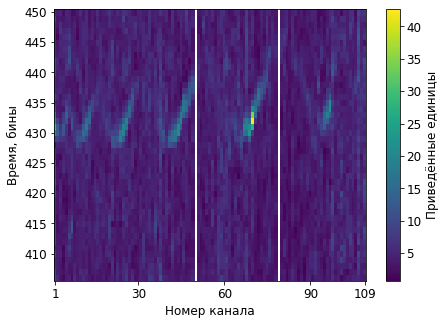

(<Figure size 504x360 with 2 Axes>,
 <AxesSubplot:xlabel='Номер канала', ylabel='Время, бины'>)

In [27]:
exp_plots.plot_signals_frame(event, window=N)

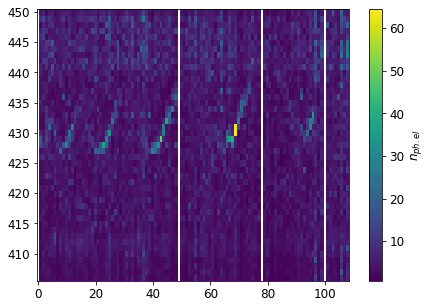

In [28]:
frame, channels = read_deconv_frame(event.id_)

fig, ax = plt.subplots(figsize=(7, 5))
mesh = ax.pcolormesh(channels, signal_t, frame, shading='nearest')
cbar = plt.colorbar(mesh)
cbar.set_label('$n_{{ph.el}}$')
plt.show()

# Выделение сигнала

$\Theta = (n_{EAS}, t, \sigma_t)$

In [29]:
sample, signal_t = read_deconv_result(event_id, i_ch)
mean_n_phels = event.mean_n_photoelectrons[i_ch]

def mean_n_phels_from_sample(sample):
    sample = sample[:, rireff.L :  -rireff.L]
    return np.median(sample)

print(mean_n_phels, mean_n_phels_from_sample(sample))

2.580146498098159 3.958286493827466


# MCMC

In [30]:
sample_original = sample
signal_t_original = signal_t

sample = sample[:, 10 : -10]
signal_t = signal_t[10 : -10]

In [31]:
theta_estimation = np.squeeze(sigrec.estimate_theta_from_sample(sample, signal_t, 1))
loglike_fast = sigrec.get_signal_reconstruction_loglike(sample, signal_t, mean_n_phels, simulate_packets=False)
loglike_slow = sigrec.get_signal_reconstruction_loglike(sample, signal_t, mean_n_phels, simulate_packets=True)

for ll, name in zip([loglike_fast, loglike_slow], ['fast', 'slow']):
    ll(theta_estimation)
    utils.timer(lambda *a, **kw: name)(ll)(theta_estimation)

loglike(fast) took 0.0003095680003752932 seconds to complete.
loglike(slow) took 0.00042165000195382163 seconds to complete.


In [32]:
logprior = sigrec.get_logprior(sample, signal_t, mean_n_phels)

In [33]:
def lazy_logposterior(logprior, loglike):
    def logposterior(theta):
        logp = logprior(theta)
        return logp if np.isinf(logp) else logp + loglike(theta)
    return logposterior

In [48]:
n_walkers = 512

tau = 200

result = mcmc.run_mcmc(
    logposterior=lazy_logposterior(logprior, loglike_slow),
    init_point=sigrec.estimate_theta_from_sample(sample, signal_t, n_walkers),
    config=mcmc.SamplingConfig(
        n_walkers=n_walkers,
        n_samples=5 * tau,
        progress_bar=True,
        starting_points_strategy='given',
        autocorr_estimation_each=3000,
        debug_acceptance_fraction_each=500,
    )
)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/njvh/Documents/Science/sphere/thesis/thenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 50%|█████     | 501/1000 [01:31<01:31,  5.43it/s]
 Current acc. frac.:0.498
100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]
 Current acc. frac.:0.492



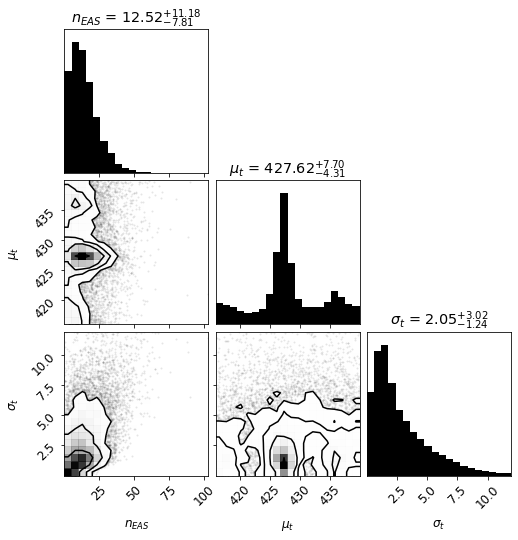

In [49]:
theta_sample = mcmc.extract_independent_sample(result.sampler)
sigrec_plots.plot_theta_sample(theta_sample)

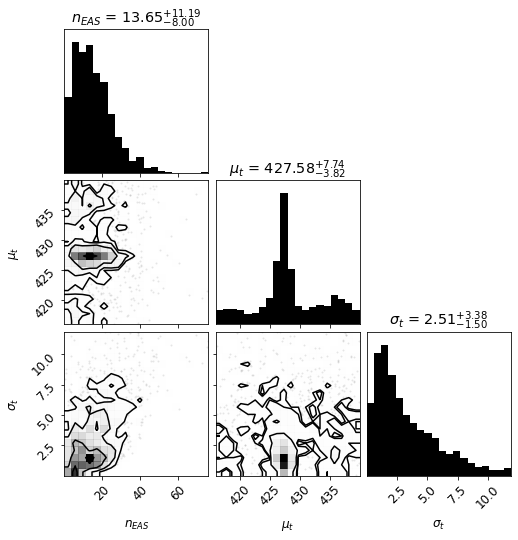

In [45]:
theta_sample = mcmc.extract_independent_sample(result.sampler, tau_override=tau)
sigrec_plots.plot_theta_sample(theta_sample)

In [50]:
from scipy.stats import norm
from IPython.display import clear_output

fig, ax = dec_plots.plot_bayesian_mean_estimation(None, sample_original, rireff.L, signal_t=signal_t_original)

def plot_theta(theta):
    n_eas_mean, t_mean, sigma_mean = theta        
    packet_t = np.linspace(signal_t[0], signal_t[-1], 500)
    packet_y = mean_n_phels + n_eas_mean * norm.pdf(packet_t, loc=t_mean, scale=sigma_mean)
    ax.plot(packet_t, packet_y, color='red')

# plot_theta(theta_sample.mean(axis=0))

for i in range(50):
    plot_theta(theta_sample[np.random.randint(theta_sample.shape[0]), :])

# for i in range(10):
#     plot_theta(np.squeeze(sigrec.estimate_theta_from_sample(sample, signal_t, 1)))

fig.savefig('temp.jpg')
clear_output()
print('see temp.jpg')

see temp.jpg
